In [1]:
import re
import regex
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.metrics import  roc_auc_score, roc_curve
%matplotlib inline

In [2]:
df=pd.read_csv('I:/Aasha/Data Science/project/Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df_shape = df.shape
print(f"No. of Datapoints : {df_shape[0]}")
print(f"No. of Features : {df_shape[1]}")

No. of Datapoints : 568454
No. of Features : 10


In [5]:
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [6]:
df[df.duplicated()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


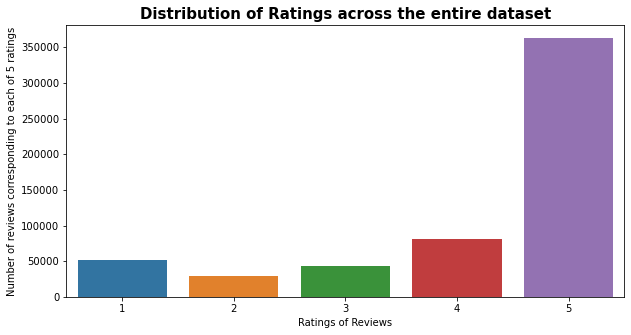

1     52268
2     29769
3     42640
4     80655
5    363122
Name: Score, dtype: int64


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,5))
sns.countplot(df['Score'])
plt.title("Distribution of Ratings across the entire dataset", fontweight='bold', fontsize=15)
plt.xlabel("Ratings of Reviews")
plt.ylabel("Number of reviews corresponding to each of 5 ratings")
plt.show();

print(df['Score'].value_counts().sort_index());

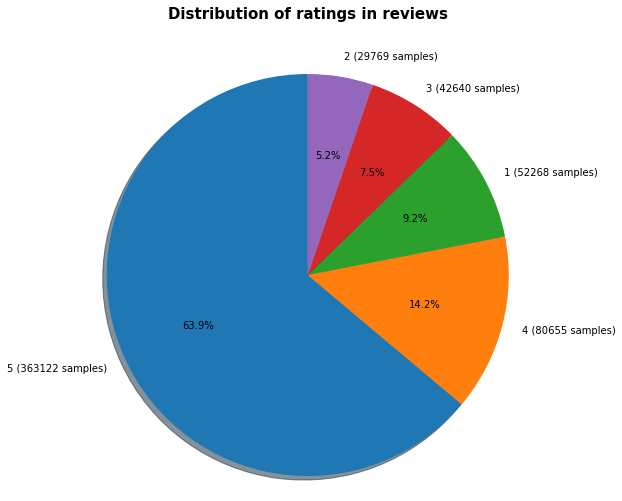

In [8]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Score"].value_counts()[k]} samples)' for k in df['Score'].value_counts().keys()]
sizes = dict(df['Score'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Distribution of ratings in reviews",pad=40, fontweight='bold', fontsize=15)
plt.show();

In [9]:
mask_duplicated_reviews = df.duplicated(subset=["UserId","Time","Text"], keep='first')
count_duplicated_reviews = mask_duplicated_reviews.value_counts()

sum_reviews = count_duplicated_reviews.sum()
perc_duplicated_reviews = (count_duplicated_reviews/sum_reviews) * 100

#sum_reviews
perc_duplicated_reviews

False    69.291798
True     30.708202
dtype: float64

In [10]:
df = df[~mask_duplicated_reviews]

print(f"Updated No. of Datapoints : {df.shape[0]}")

Updated No. of Datapoints : 393892


Check and Remove 3 Star(Neutral) Reviews


In [11]:
print(f"{df[df['Score']==3].shape[0]}/{df.shape[0]} ({round((df[df['Score']==3].shape[0]/df.shape[0])*100,2)}% of the total)")

29768/393892 (7.56% of the total)


In [12]:
#Discard all reviews having a Score of 3
print(f"No. of Datapoints BEFORE discarding : {df.shape[0]}")

df = df[df["Score"]!=3]

print(f"No. of Datapoints AFTER discarding : {df.shape[0]}")

No. of Datapoints BEFORE discarding : 393892
No. of Datapoints AFTER discarding : 364124


Discarding reviews having inconsistencies
Helpfulness numerator should not exceed Helpfulness denominato

In [13]:
df[df['HelpfulnessNumerator']>df['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [14]:
print(f"No. of Datapoints BEFORE discarding : {df.shape[0]}")

df = df[df["HelpfulnessNumerator"] <= df["HelpfulnessDenominator"]]

print(f"No. of Datapoints AFTER discarding : {df.shape[0]}")

No. of Datapoints BEFORE discarding : 364124
No. of Datapoints AFTER discarding : 364122


In [15]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
#replace HelpfulnessNumerator and HelpfulnessDenominator Feature into one feature indicating the HelpfulnessPercentage
df["Helpfulness_Perc"] = df[["HelpfulnessNumerator","HelpfulnessDenominator"]].apply(lambda x: ((x[0]/x[1])*100.0) if x[1] else 0.0, axis=1)
df = df.drop(["HelpfulnessNumerator","HelpfulnessDenominator"], axis=1)
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_Perc
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,100.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,100.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,100.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.0


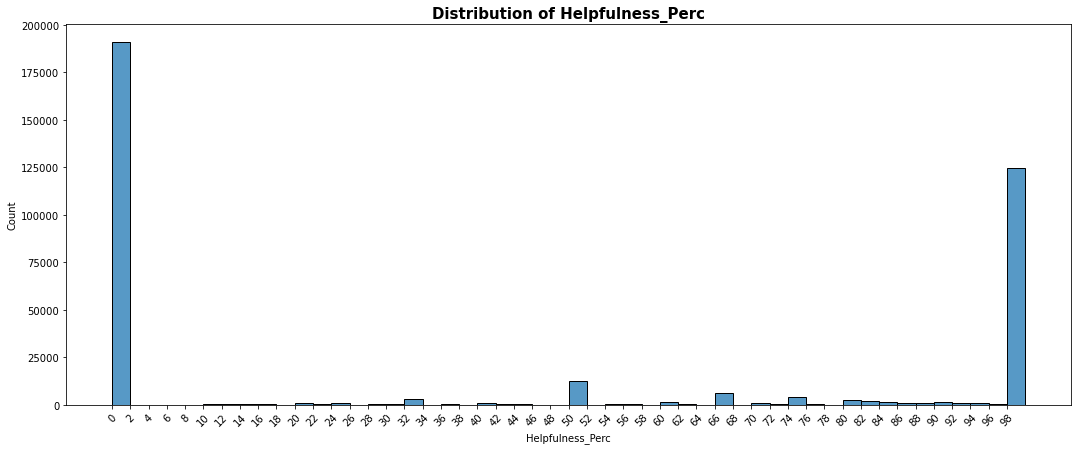

In [17]:
plt.figure(figsize=(18,7))
sns.histplot(data=df["Helpfulness_Perc"], bins=50)
plt.title("Distribution of Helpfulness_Perc",fontweight='bold', fontsize=15)
plt.xticks(range(0,100,2), rotation=45)
plt.show();

In [18]:


df[df['Helpfulness_Perc']==0]

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_Perc
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,0.0
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,0.0
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,0.0
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,0.0
...,...,...,...,...,...,...,...,...,...
568447,568448,B001EO7N10,APWCOAVILK94B,"Real Named Person ""wowzee""",5,1322524800,"If its all natural, this is like panacea of Sp...","Hoping there is no MSG in this, this tastes ex...",0.0
568448,568449,B001EO7N10,A1F6BHEYB7R6R7,James Braley,5,1308096000,Very large ground spice jars.,My only complaint is that there's so much of i...,0.0
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,0.0
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,0.0


In [19]:
# Assigning Helpfulness indicator
df.loc[df["Helpfulness_Perc"] >= 75, 'Helpfulness_indicator'] = 'Useful'
df.loc[(df["Helpfulness_Perc"] > 40) & (df["Helpfulness_Perc"] < 75), 'Helpfulness_indicator'] = 'Intermediate'
df.loc[(df["Helpfulness_Perc"] > 0) & (df["Helpfulness_Perc"] <= 40), 'Helpfulness_indicator'] = 'Not Useful'
df.loc[df["Helpfulness_Perc"] == 0, 'Helpfulness_indicator'] = 'Not Available'

df = df.drop(["Helpfulness_Perc"], axis=1)

df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_indicator
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available


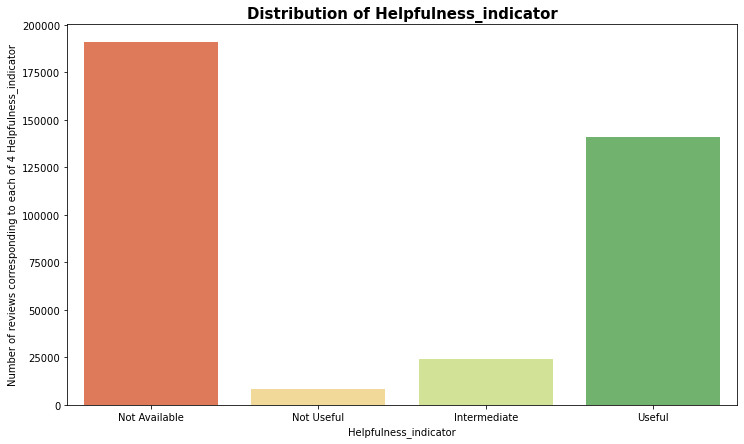

Not Available    190788
Not Useful         8576
Intermediate      23951
Useful           140807
Name: Helpfulness_indicator, dtype: int64


In [20]:
plt.figure(figsize=(12,7))
sns.countplot(df['Helpfulness_indicator'], palette=sns.color_palette("RdYlGn", 4), order=["Not Available","Not Useful","Intermediate","Useful"])
plt.title("Distribution of Helpfulness_indicator",fontweight='bold', fontsize=15)
plt.xlabel("Helpfulness_indicator")
plt.ylabel("Number of reviews corresponding to each of 4 Helpfulness_indicator")
plt.show();

print(df['Helpfulness_indicator'].value_counts()[[0,3,2,1]]);


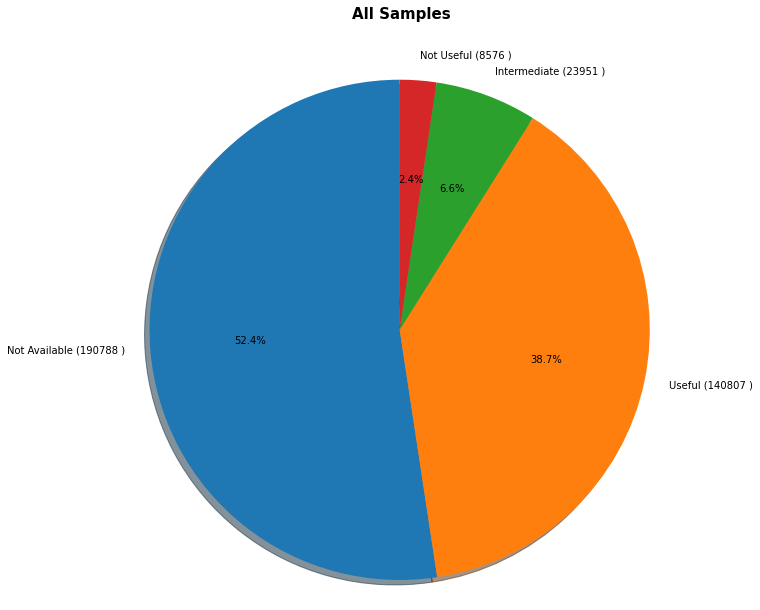

In [21]:
 #Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Helpfulness_indicator"].value_counts()[k]} )' for k in df['Helpfulness_indicator'].value_counts().keys()]
sizes = dict(df['Helpfulness_indicator'].value_counts()).values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("All Samples", pad=40,fontweight='bold', fontsize=15)
plt.show();

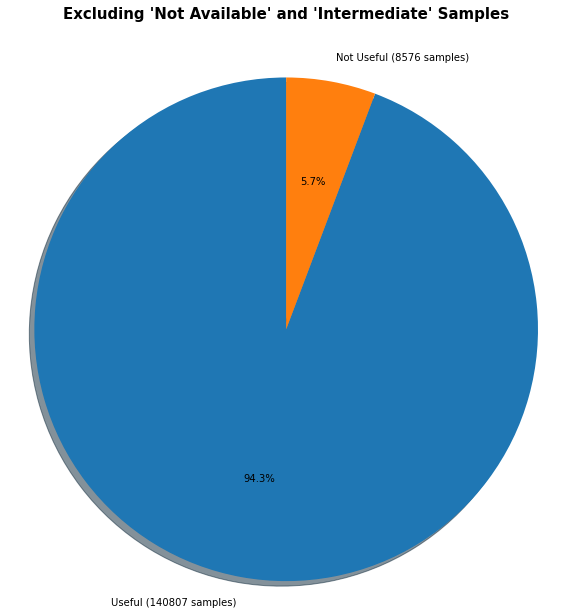

In [22]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Helpfulness_indicator"].value_counts()[k]} samples)' for k in ['Useful','Not Useful']]
sizes = dict(df['Helpfulness_indicator'].value_counts())
sizes.pop('Not Available')
sizes.pop('Intermediate')
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Excluding 'Not Available' and 'Intermediate' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

Assigning 'Sentiment_Class' Feature
Score > 3 (4,5) -> Positive
Score < 3 (1,2) -> Negative

In [23]:
df.loc[df["Score"] > 3, 'Sentiment_Class'] = 'Positive'
df.loc[df["Score"] < 3, 'Sentiment_Class'] = 'Negative'

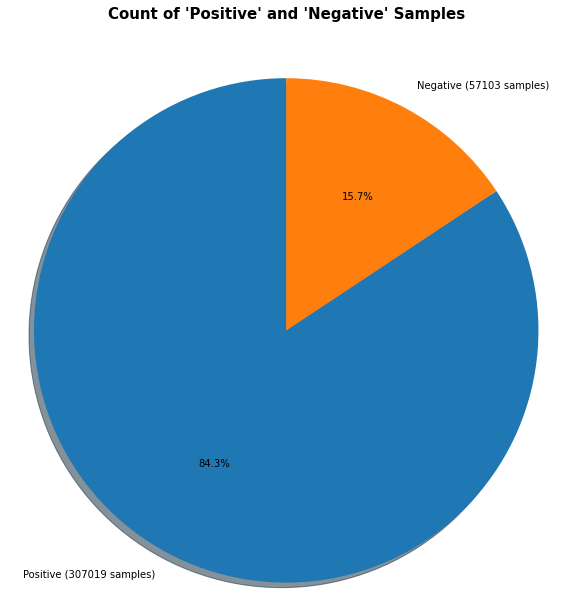

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [f'{k} ({df["Sentiment_Class"].value_counts()[k]} samples)' for k in df['Sentiment_Class'].value_counts().keys()]
sizes = dict(df['Sentiment_Class'].value_counts())
sizes = sizes.values()

fig1, ax1 = plt.subplots(figsize=(10,10));
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title("Count of 'Positive' and 'Negative' Samples", pad=40, fontweight='bold', fontsize=15)
plt.show();

Assigning 'Review_Word_Count' Feature


In [25]:
df["Review_Word_Count"] = df["Text"].apply(lambda x: len(x.split()))
df.head()

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Helpfulness_indicator,Sentiment_Class,Review_Word_Count
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Useful,Positive,48
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not Available,Negative,31
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Useful,Positive,94
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Useful,Negative,41
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Not Available,Positive,27


EDA 2 (After Data Cleaning, FE1)
What is the distribution of useful and non-useful reviews in each of the set of Positive and Negative Reviews.

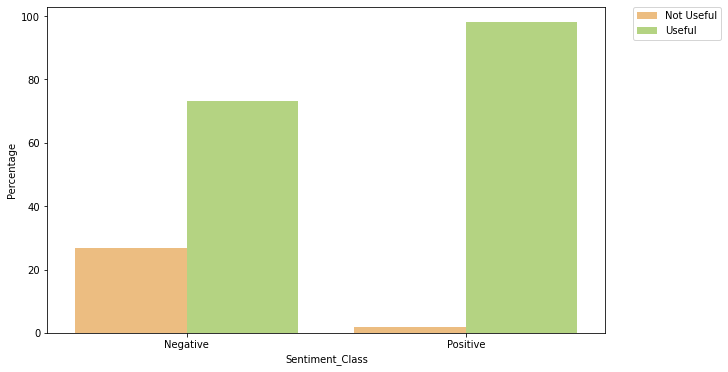

,Sentiment_Class,Helpfulness_indicator,Percentage
0,Negative,Useful,73.081516
1,Negative,Not Useful,26.918484
2,Positive,Useful,98.035875
3,Positive,Not Useful,1.964125


In [26]:
df_temp = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate")]
df_temp_1 = df_temp["Helpfulness_indicator"].groupby(df_temp["Sentiment_Class"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_temp_1, x="Sentiment_Class", y="Percentage", hue="Helpfulness_indicator", hue_order=["Not Useful","Useful"], palette=sns.color_palette("RdYlGn", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
df_temp_1

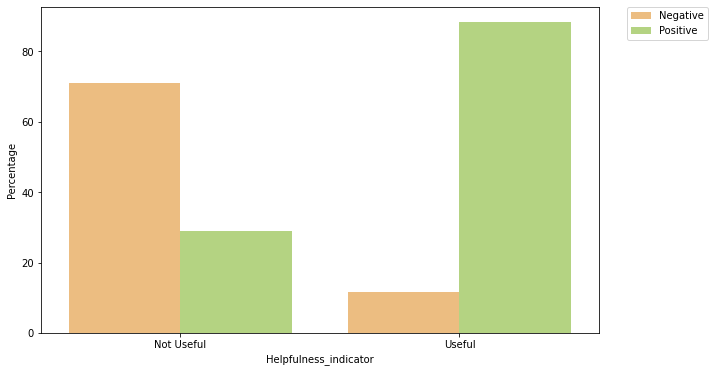

,Helpfulness_indicator,Sentiment_Class,Percentage
0,Not Useful,Negative,70.965485
1,Not Useful,Positive,29.034515
2,Useful,Positive,88.265498
3,Useful,Negative,11.734502


In [27]:
#What is the distribution of Positive and Negative Reviews in each of the set of useful and non-useful reviews
df_temp = df[(df["Helpfulness_indicator"]!= "Not Available") & (df["Helpfulness_indicator"]!= "Intermediate")]
df_temp_1 = df_temp["Sentiment_Class"].groupby(df_temp["Helpfulness_indicator"]).value_counts(normalize=True)
df_temp_1 = df_temp_1*100 
df_temp_1 = df_temp_1.rename("Percentage").reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=df_temp_1, x="Helpfulness_indicator", y="Percentage", hue="Sentiment_Class", hue_order=["Negative","Positive"], palette=sns.color_palette("RdYlGn", 2));
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.show()
df_temp_1

Wordcloud for Reviews.
Plotting word cloud to understand the top words that have occured most frequently in the reviews.

There are 129114833 words in the combination of all positive reviews.


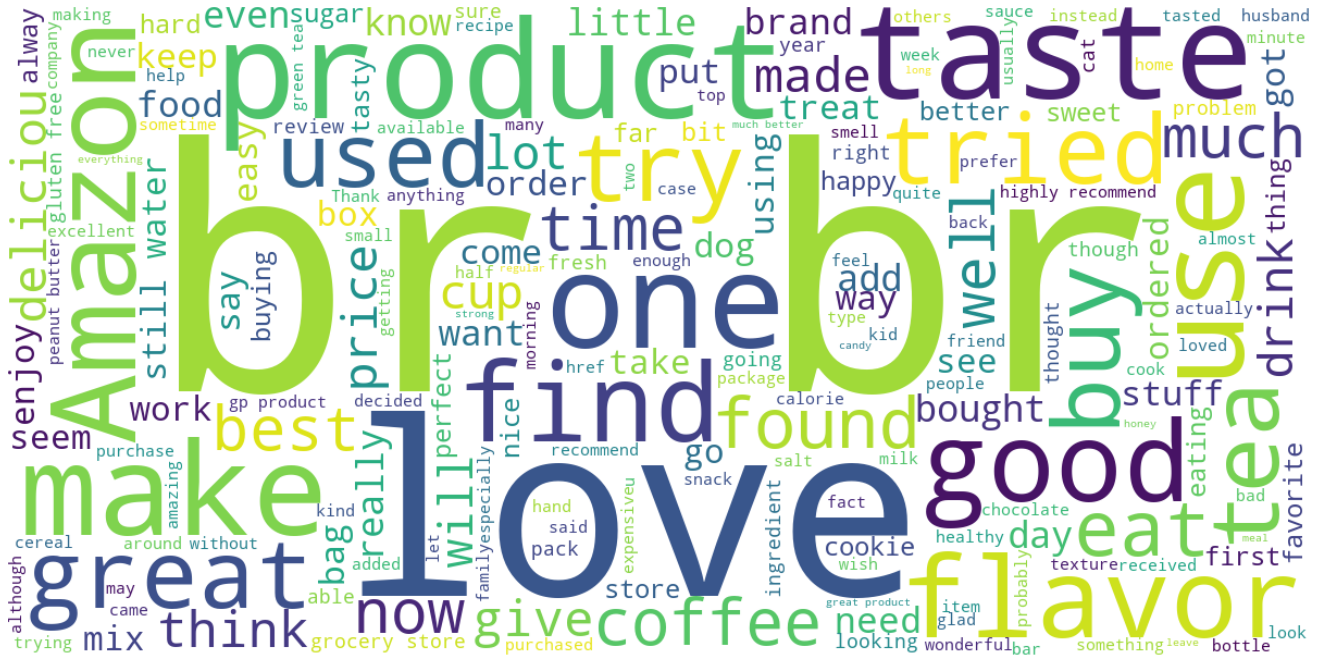

In [29]:
#Plotting word cloud to understand the top words that have occured most frequently in the POSITIVE reviews.
df_positive = df[df["Sentiment_Class"] == "Positive"]
text = " ".join(review for review in df_positive["Text"])
print ("There are {} words in the combination of all positive reviews.".format(len(text)))

default_stopwords=set(STOPWORDS)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 26713613 words in the combination of all negative reviews.


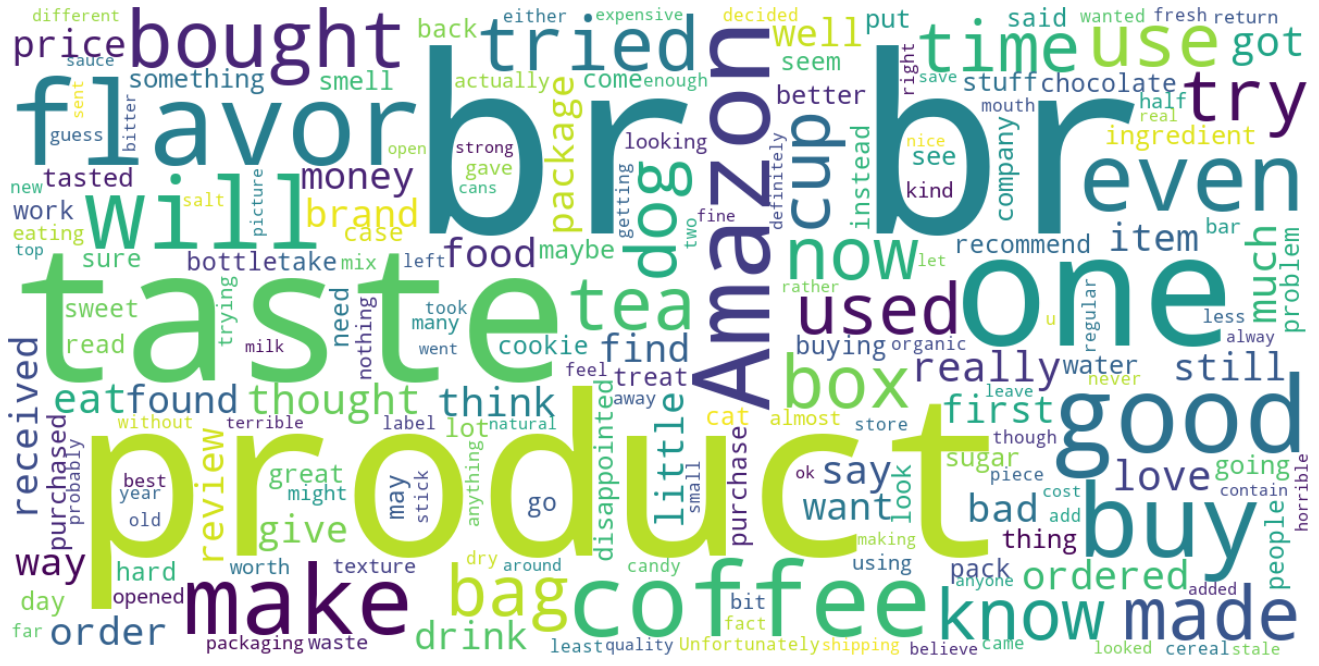

In [30]:
#Plotting word cloud to understand the top words that have occured most frequently in the NEGATIVE reviews.

df_negative = df[df["Sentiment_Class"] == "Negative"]
text = " ".join(review for review in df_negative["Text"])
print ("There are {} words in the combination of all negative reviews.".format(len(text)))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=default_stopwords, background_color="white", width=1200, height=600).generate(text)

# Display the generated image:
plt.figure(figsize=(30,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
df.groupby('Score')['ProductId'].count()

Score
1     36302
2     20801
4     56086
5    250933
Name: ProductId, dtype: int64

In [32]:

import re
import regex
import pandas as pd
import numpy as np
import plotly.express as px
from collections import Counter
import nltk 
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [33]:
df2=df[df['Score']!=3]

In [34]:
x=df2['Text']
y=df2['Score']


In [35]:
y_dict = {1:0,2:0,4:1,5:1}
y=df2['Score'].map(y_dict)


In [36]:
from sklearn.feature_extraction.text import CountVectorizer


In [37]:
c = CountVectorizer(stop_words='english')                  # to ignore all english stopwords
x_c = c.fit_transform(x)


In [38]:
x_c.shape


(364122, 114965)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
x_train,x_test,y_train,y_test = train_test_split(x_c,y)

ml = log.fit(x_train, y_train)
ml.score(x_test,y_test)


0.9248278059122716

In [40]:
w = c.get_feature_names()
coef = ml.coef_.tolist()[0]
coef_df = pd.DataFrame({'Word':w, 'Coefficient':coef})
coef_df

,Word,Coefficient
0,00,-0.365599
1,000,0.143833
2,0000,0.190314
3,000001,-0.012355
4,00001,-0.008369
...,...,...
114960,çaykur,0.001542
114961,çelem,-0.180519
114962,être,0.036613
114963,île,0.015733


In [41]:
coef_df=coef_df.sort_values(['Coefficient','Word'],ascending=False)


In [42]:
coef_df.head(20)


,Word,Coefficient
80596,pleasantly,4.005150
5865,addicting,3.119441
39212,drawback,2.765777
39070,downside,2.552404
102853,terrific,2.432316
94663,skeptical,2.374160
40133,easiest,2.361694
112888,wonderfully,2.325315
87963,resist,2.286708
53672,heavenly,2.232292


In [43]:
coef_df.tail(20)


,Word,Coefficient
106697,ugh,-2.198998
114343,yuk,-2.210273
110400,vomited,-2.246402
33746,culprit,-2.266292
67894,mediocre,-2.339181
24948,cancelled,-2.419174
38115,dissapointing,-2.462781
56226,ick,-2.587605
41116,embarrassed,-2.631968
37561,disappointment,-2.687054


In [44]:
def text_fit(x,y,nlp_model,ml_model,coef_show=1):
    x_c = nlp_model.fit_transform(x)
    print('No. of features:{}'.format(x_c.shape[1]))
    x_train,x_test,y_train,y_test = train_test_split(x_c,y)
    
    ml = ml_model.fit(x_train, y_train)
    acc = ml.score(x_test,y_test)
    
    if coef_show==1:
        w = nlp_model.get_feature_names()
        coef = ml.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Word':w, 'Coefficient':coef})
        coef_df=coef_df.sort_values(['Coefficient','Word'],ascending=False)
        print('\n')
        print('Top 20 Positive words:')
        print(coef_df.head(20))
        print('\n')
        print('Top 20 Negative words:')
        print(coef_df.tail(20))

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(stop_words='english') 


In [46]:
from sklearn.linear_model import LogisticRegression


In [47]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver='liblinear')
text_fit(x,y,c,log)


No. of features:114965


Top 20 Positive words:
              Word  Coefficient
80596   pleasantly     2.961466
39070     downside     2.340669
5865     addicting     2.339892
55026       hooked     2.195378
40133      easiest     2.156525
22851   breastmilk     2.108566
85233       ramune     1.979834
69166      mindful     1.969648
91060        saves     1.966093
43190     exceeded     1.943476
94663    skeptical     1.939924
102853    terrific     1.938561
20923      biscoff     1.923031
81323     popcorns     1.920604
22724        bravo     1.910328
54134   hesitation     1.902141
43210    excellant     1.890900
39212     drawback     1.873782
96136       solved     1.858953
114380    yummiest     1.852877


Top 20 Negative words:
                  Word  Coefficient
88941           ripoff    -2.114190
106697             ugh    -2.160071
67894         mediocre    -2.160645
107696    unimpressive    -2.176283
41341           emptor    -2.180594
102841        terrible    -2.183143
381

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score


In [53]:

def predict(x,y,nlp_model,ml_model, coef_show=1):
    #Fitting the model
    x_c = nlp_model.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x_c,y)
    ml = ml_model.fit(x_train, y_train)
    predictions = ml.predict(x_test)
    
    #Performance Metrics
    cm = confusion_matrix(predictions, y_test)
    print('Confusion Matrix: \n{}'.format(cm))
    acc = accuracy_score(predictions,y_test)
    print('Accuracy:{}'.format(acc))
    ras=roc_auc_score(predictions, y_test)
    
    print(ras)
    fpr, tpr, thresholds = roc_curve(y_test, predictions)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
     
    if coef_show==1:
        w = nlp_model.get_feature_names()
        coef = ml.coef_.tolist()[0]
        coef_df = pd.DataFrame({'Word':w, 'Coefficient':coef})
        coef_df=coef_df.sort_values(['Coefficient','Word'],ascending=False)
        print('\n')
        print('Top 20 Positive words:')
        print(coef_df.head(20))
        print('\n')
        print('Top 20 Negative words:')
        print(coef_df.tail(20))

In [54]:
c= CountVectorizer()
lr = LogisticRegression(solver='liblinear')

Confusion Matrix: 
[[10058  2342]
 [ 4109 74522]]
Accuracy:0.9291340312640749
0.8794361443672589


Top 20 Positive words:
              Word  Coefficient
80797   pleasantly     2.793921
5868     addicting     2.644562
111795     welcome     2.306464
55152       hooked     2.248143
94884    skeptical     2.208209
87434     relieved     2.171142
88168       resist     2.150239
91120    satisfies     1.963483
85436       ramune     1.888694
39857   duplicates     1.842211
65753           ma     1.815885
102287      tastey     1.811711
102296    tastiest     1.777777
61184        kenzi     1.767496
39282     drawback     1.764087
35754    delighted     1.758003
35704    delicious     1.757579
102577     tearing     1.757513
79319     perruche     1.745793
63559        lends     1.742436


Top 20 Negative words:
                  Word  Coefficient
86896      reformulate    -2.037041
30346        commodity    -2.048226
56355              ick    -2.066733
38182    dissapointing    -2.122054
1

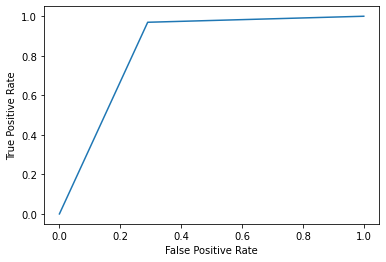

In [55]:
predict(x,y,c,lr)


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
text_fit(x,y,tfidf,lr,0)


No. of features:114965


Confusion Matrix: 
[[ 9425  1703]
 [ 5046 74857]]
Accuracy:0.9258604211752041
0.8919055227711263


Top 20 Positive words:
              Word  Coefficient
51297        great    13.814020
35639    delicious    11.739206
20307         best    11.352879
78885      perfect    10.205764
43220    excellent     9.445586
54306       highly     9.241455
65104        loves     8.756859
65068         love     8.168617
112879   wonderful     8.070733
10992      awesome     7.580533
7821       amazing     7.336979
50507         good     7.258296
72814         nice     6.845270
44750     favorite     6.764038
80604      pleased     6.715354
95446       smooth     6.467128
49852         glad     6.464400
80596   pleasantly     6.315828
55026       hooked     6.298172
114424       yummy     6.253712


Top 20 Negative words:
                  Word  Coefficient
55080           hoping    -5.462703
107940      unpleasant    -5.535360
113149           worse    -5.536309
114316            yuck    -5.667917
1

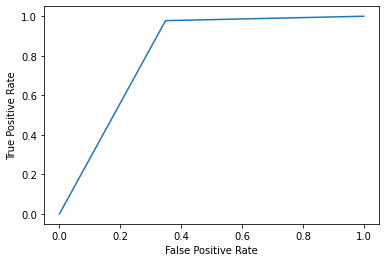

In [57]:
predict(x,y,tfidf,lr)
